<a href="https://colab.research.google.com/github/HellenNamulinda/zindi-competitions/blob/master/road_segment_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q --upgrade fastcore fastai

     |████████████████████████████████| 59 kB 4.7 MB/s 
     |████████████████████████████████| 197 kB 17.4 MB/s 


In [2]:
import requests
from tqdm.auto import tqdm

In [3]:
# Data url and token
data_url = 'https://api.zindi.africa/v1/competitions/road-segment-identification/files/'
file_names =['Images.zip','Train.csv','Test.csv']
token = {'auth_token': ' '} # Use your own token

In [4]:
def zindi_data_downloader(url, token, file_name):
  # Print current download url and file
  print('URL: {}  '.format(url), 'File: {}'.format(file_name))
  # Get the competition data
  competition_data = requests.post(url = url, data= token, stream=True)
  
  # Progress bar monitor download
  pbar = tqdm(desc=file_name, total=int(competition_data.headers.get('content-length', 0)), unit='B', unit_scale=True, unit_divisor=512)
  # Create and Write the data to colab drive in chunks
  handle = open(file_name, "wb")
  for chunk in competition_data.iter_content(chunk_size=512): # Download the data in chunks
      if chunk: # filter out keep-alive new chunks
              handle.write(chunk)
      pbar.update(len(chunk))
  handle.close()
  pbar.close()

In [5]:
#Downloading data
for file_name in file_names:
  zindi_data_downloader(data_url+file_name, token, file_name)

URL: https://api.zindi.africa/v1/competitions/road-segment-identification/files/Images.zip   File: Images.zip


Images.zip:   0%|          | 0.00/3.04G [00:00<?, ?B/s]

URL: https://api.zindi.africa/v1/competitions/road-segment-identification/files/Train.csv   File: Train.csv


Train.csv:   0%|          | 0.00/191k [00:00<?, ?B/s]

URL: https://api.zindi.africa/v1/competitions/road-segment-identification/files/Test.csv   File: Test.csv


Test.csv:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

In [6]:
from fastai.vision.all import *
import pandas as pd

train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

print('Training shape: {}'.format(train.shape))
print('Testing shape: {}'.format(test.shape))

Training shape: (7000, 2)
Testing shape: (3000, 1)


In [7]:
train.head()

,Image_ID,Target
0,ID_0073qfb8,0
1,ID_00gy3vH2,1
2,ID_00uB3UFr,0
3,ID_012xZpNw,1
4,ID_014GgMRb,1


In [8]:
test.head()

,Image_ID
0,ID_01c6i2wd
1,ID_03sPqBLY
2,ID_06ZKUQFl
3,ID_06gzqIwK
4,ID_08kWat36


In [9]:
# Unzip images
!unzip -q Images.zip

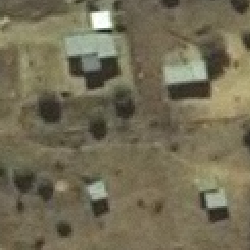

In [10]:
Image.open('Images/ID_08kWat36.tif')

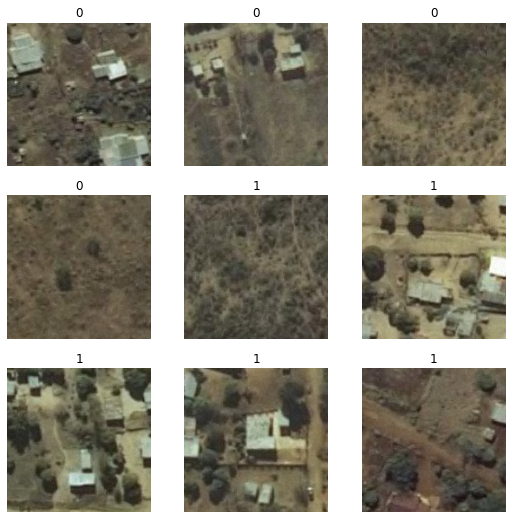

In [11]:
# Create the dataloaders
dls = ImageDataLoaders.from_df(train, path='Images', suff='.tif') # See the docs for adding augmentations etc
dls.show_batch() # View a batch with labels

SuggestedLRs(valley=0.0008317637839354575)

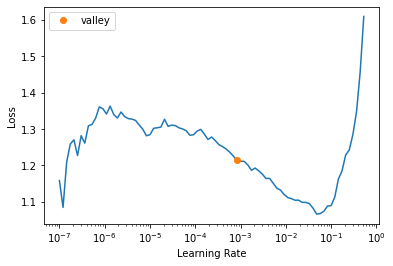

In [22]:
#Training the model
learn = vision_learner(dls, resnet18, metrics=[error_rate, accuracy])
learn.lr_find()

In [26]:
learn.fine_tune(2, 1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.087364,0.708903,0.189286,0.810714,00:22


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.080845,0.764441,0.210714,0.789286,00:26
1,0.044780,0.785207,0.195000,0.805000,00:26


In [27]:
# Testing
# Make a test dataloader and get predictions
tdl = learn.dls.test_dl(test['Image_ID'].map(lambda s: 'Images/'+s+'.tif').values)
preds = learn.get_preds(dl=tdl)

In [ ]:
# Store the predicted probabilities (we want P(Target=1))
test['Target'] = [float(p[1]) for p in preds[0]]
test.head()

In [16]:
# Save
test.to_csv('submission3.csv', index=False)